# I. Just Visualizing the Problem

In [28]:
# -*- coding: utf-8 -*-
import cv2
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import scipy.spatial as sp

In [29]:
# data/imm_face_db
# aaa.jpg + aaa.asf + bbb.jpg + bbb.asf...
filenames_without_extension = [filename.split('.')[0] for filename in os.listdir('imm_face_db') if filename.endswith('.jpg')]
set_of_images = set(filenames_without_extension)
jpgs = [filename + '.jpg' for filename in set_of_images]
asfs = [filename + '.asf' for filename in set_of_images]
# read the images and asfs
images = [cv2.imread('imm_face_db/' + jpg) for jpg in jpgs]
asfs = [open('imm_face_db/' + asf).read() for asf in asfs]
def extract_point_data(asf_content):
    points_list = []
    for line in asf_content.splitlines():
        # Skip comments and empty lines
        if line.startswith("#") or not line.strip():
            continue
        # Split the line into components
        parts = line.split()
        if len(parts) == 1 and parts[0].endswith("jpg"):
            # take the name of the image
            image_name = parts[0]
        # print(parts)
        if len(parts) == 7 or len(parts) == 10:  # Check if the line has 7 parts (valid point line)
            # path_num = int(parts[0])
            point_num = int(parts[4])
            x_rel = float(parts[2])
            y_rel = float(parts[3])
            # Append the tuple (point#, x rel., y rel.) to the list
            points_list.append((point_num, x_rel, y_rel))
        
    return points_list, image_name

# extract the points from asfs
points = []
names = []
for asf in asfs:
    points_one_file, name = extract_point_data(asf)
    points.append(points_one_file)
    names.append(name)
assert len(points) == len(names)
print(names)

# resize the images to the same size
min_h = min([image.shape[0] for image in images])
min_w = min([image.shape[1] for image in images])
images = [cv2.resize(image, (min_w, min_h)) for image in images] # list of images shape (n, h, w, c) where n is the number of images
print(images[0].shape) # (h, w, c)
# all to gray scale
images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images] # (n, h, w)

# we need not to # change relative coordinates to absolute coordinates
# for i in range(len(points)):
#     h, w, _ = images[i].shape
#     points[i] = np.array([(point[1] * w, point[2] * h) for point in points[i]])
#     # add 4 corners to the points
#     points[i] = np.vstack([points[i], [0, 0], [0, h - 1], [w - 1, 0], [w - 1, h - 1]])
# num_p = [point.shape[0] for point in points]
# assert len(set(num_p)) == 1

# dict of images
# key is the name of the image xxx.jpg
# value1: the image
# value2: the points
images_dict = {}

for i in range(len(names)):
    # prop = 'neutral' if '1m' in names[i] or '1f' in names[i] else 'happy' if '2m' in names[i] or '2f' in names[i] else 'other'
    images_dict[names[i]] = (images[i], points[i])

['11-1m.jpg', '33-5m.jpg', '08-5f.jpg', '36-3m.jpg', '32-2m.jpg', '24-2m.jpg', '36-6m.jpg', '29-5m.jpg', '23-4m.jpg', '27-1m.jpg', '17-1m.jpg', '27-6m.jpg', '25-2m.jpg', '26-1m.jpg', '11-5m.jpg', '39-4m.jpg', '26-4m.jpg', '17-3m.jpg', '02-2m.jpg', '27-4m.jpg', '20-2m.jpg', '04-6m.jpg', '16-3m.jpg', '30-4f.jpg', '11-2m.jpg', '09-4m.jpg', '02-4m.jpg', '28-1m.jpg', '38-4m.jpg', '40-4m.jpg', '29-4m.jpg', '13-6m.jpg', '19-1m.jpg', '10-1m.jpg', '13-3m.jpg', '32-6m.jpg', '19-5m.jpg', '30-5f.jpg', '23-1m.jpg', '06-5m.jpg', '23-3m.jpg', '34-6m.jpg', '38-1m.jpg', '36-1m.jpg', '26-3m.jpg', '33-3m.jpg', '20-3m.jpg', '05-4m.jpg', '21-5m.jpg', '03-6m.jpg', '32-5m.jpg', '21-1m.jpg', '28-5m.jpg', '13-1m.jpg', '22-6f.jpg', '20-1m.jpg', '27-3m.jpg', '08-6f.jpg', '10-2m.jpg', '38-6m.jpg', '09-6m.jpg', '33-6m.jpg', '35-2f.jpg', '24-4m.jpg', '33-2m.jpg', '27-2m.jpg', '23-6m.jpg', '30-6f.jpg', '18-2m.jpg', '35-4f.jpg', '07-1m.jpg', '40-1m.jpg', '31-5m.jpg', '15-3f.jpg', '34-2m.jpg', '30-2f.jpg', '18-6m.jpg'

We can see, from the dataset, we only have feature points for some places around the nose, but not the nose tip itself. 

But by averaging the feature points around the nose, we can get a good approximation of the nose tip and use it as the nose tip feature point. There are some images where the views are rotated, so we should weight the feature points based on the rotation. Also, we drop the top of the philtrum.

We visualize some nasal feature points in the following code.

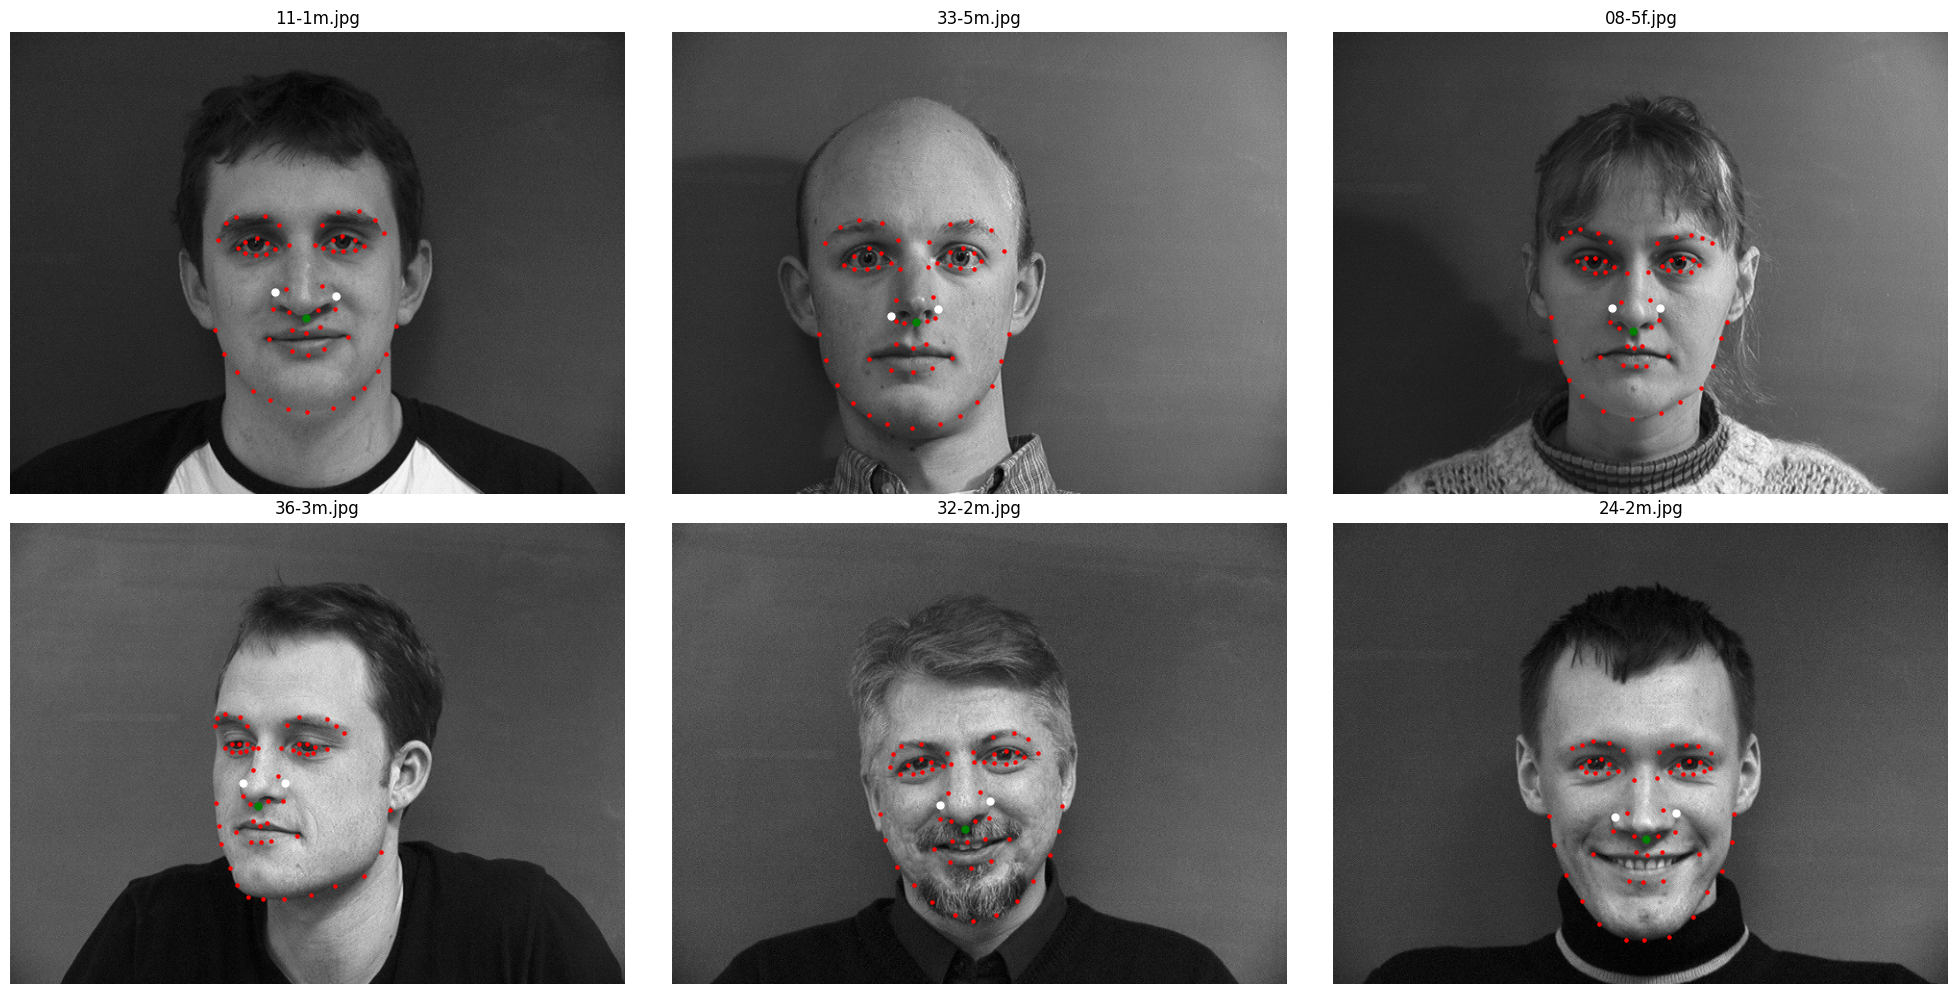

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()  # Flatten to easily index axes

idx_philtrum_top = 52  # Top of the philtrum
idx_left_nose = 49
idx_right_nose = 55

# Show the images of the first 6 images
for i in range(6):
    key = list(images_dict.keys())[i]
    image = images_dict[key][0]
    points_with_info = images_dict[key][1]  # list of tuples (point#, x rel., y rel.)
    
    points = np.array([(point[1] * image.shape[1], point[2] * image.shape[0]) for point in points_with_info])  # (N, 2)
    philtrum_top = points[idx_philtrum_top]
    left_nose = points[idx_left_nose]
    right_nose = points[idx_right_nose]
    middle = (left_nose + right_nose) / 2
    
    ax = axes[i]
    ax.imshow(image, cmap='gray')
    ax.scatter(points[:, 0], points[:, 1], s=5, c='r')
    ax.scatter(philtrum_top[0], philtrum_top[1], s=25, c='g', label="Philtrum Top")
    ax.scatter(left_nose[0], left_nose[1], s=25, c='w', label="Left Nose")
    ax.scatter(right_nose[0], right_nose[1], s=25, c='w', label="Right Nose")
    # ax.scatter(middle[0], middle[1], s=25, c='c', label="Middle")
    ax.set_title(key)
    ax.axis('off')

plt.tight_layout()
plt.show()

By averaging the nasal feature points (sometimes by some weights), we get annotation for the nose tip. The visualization:

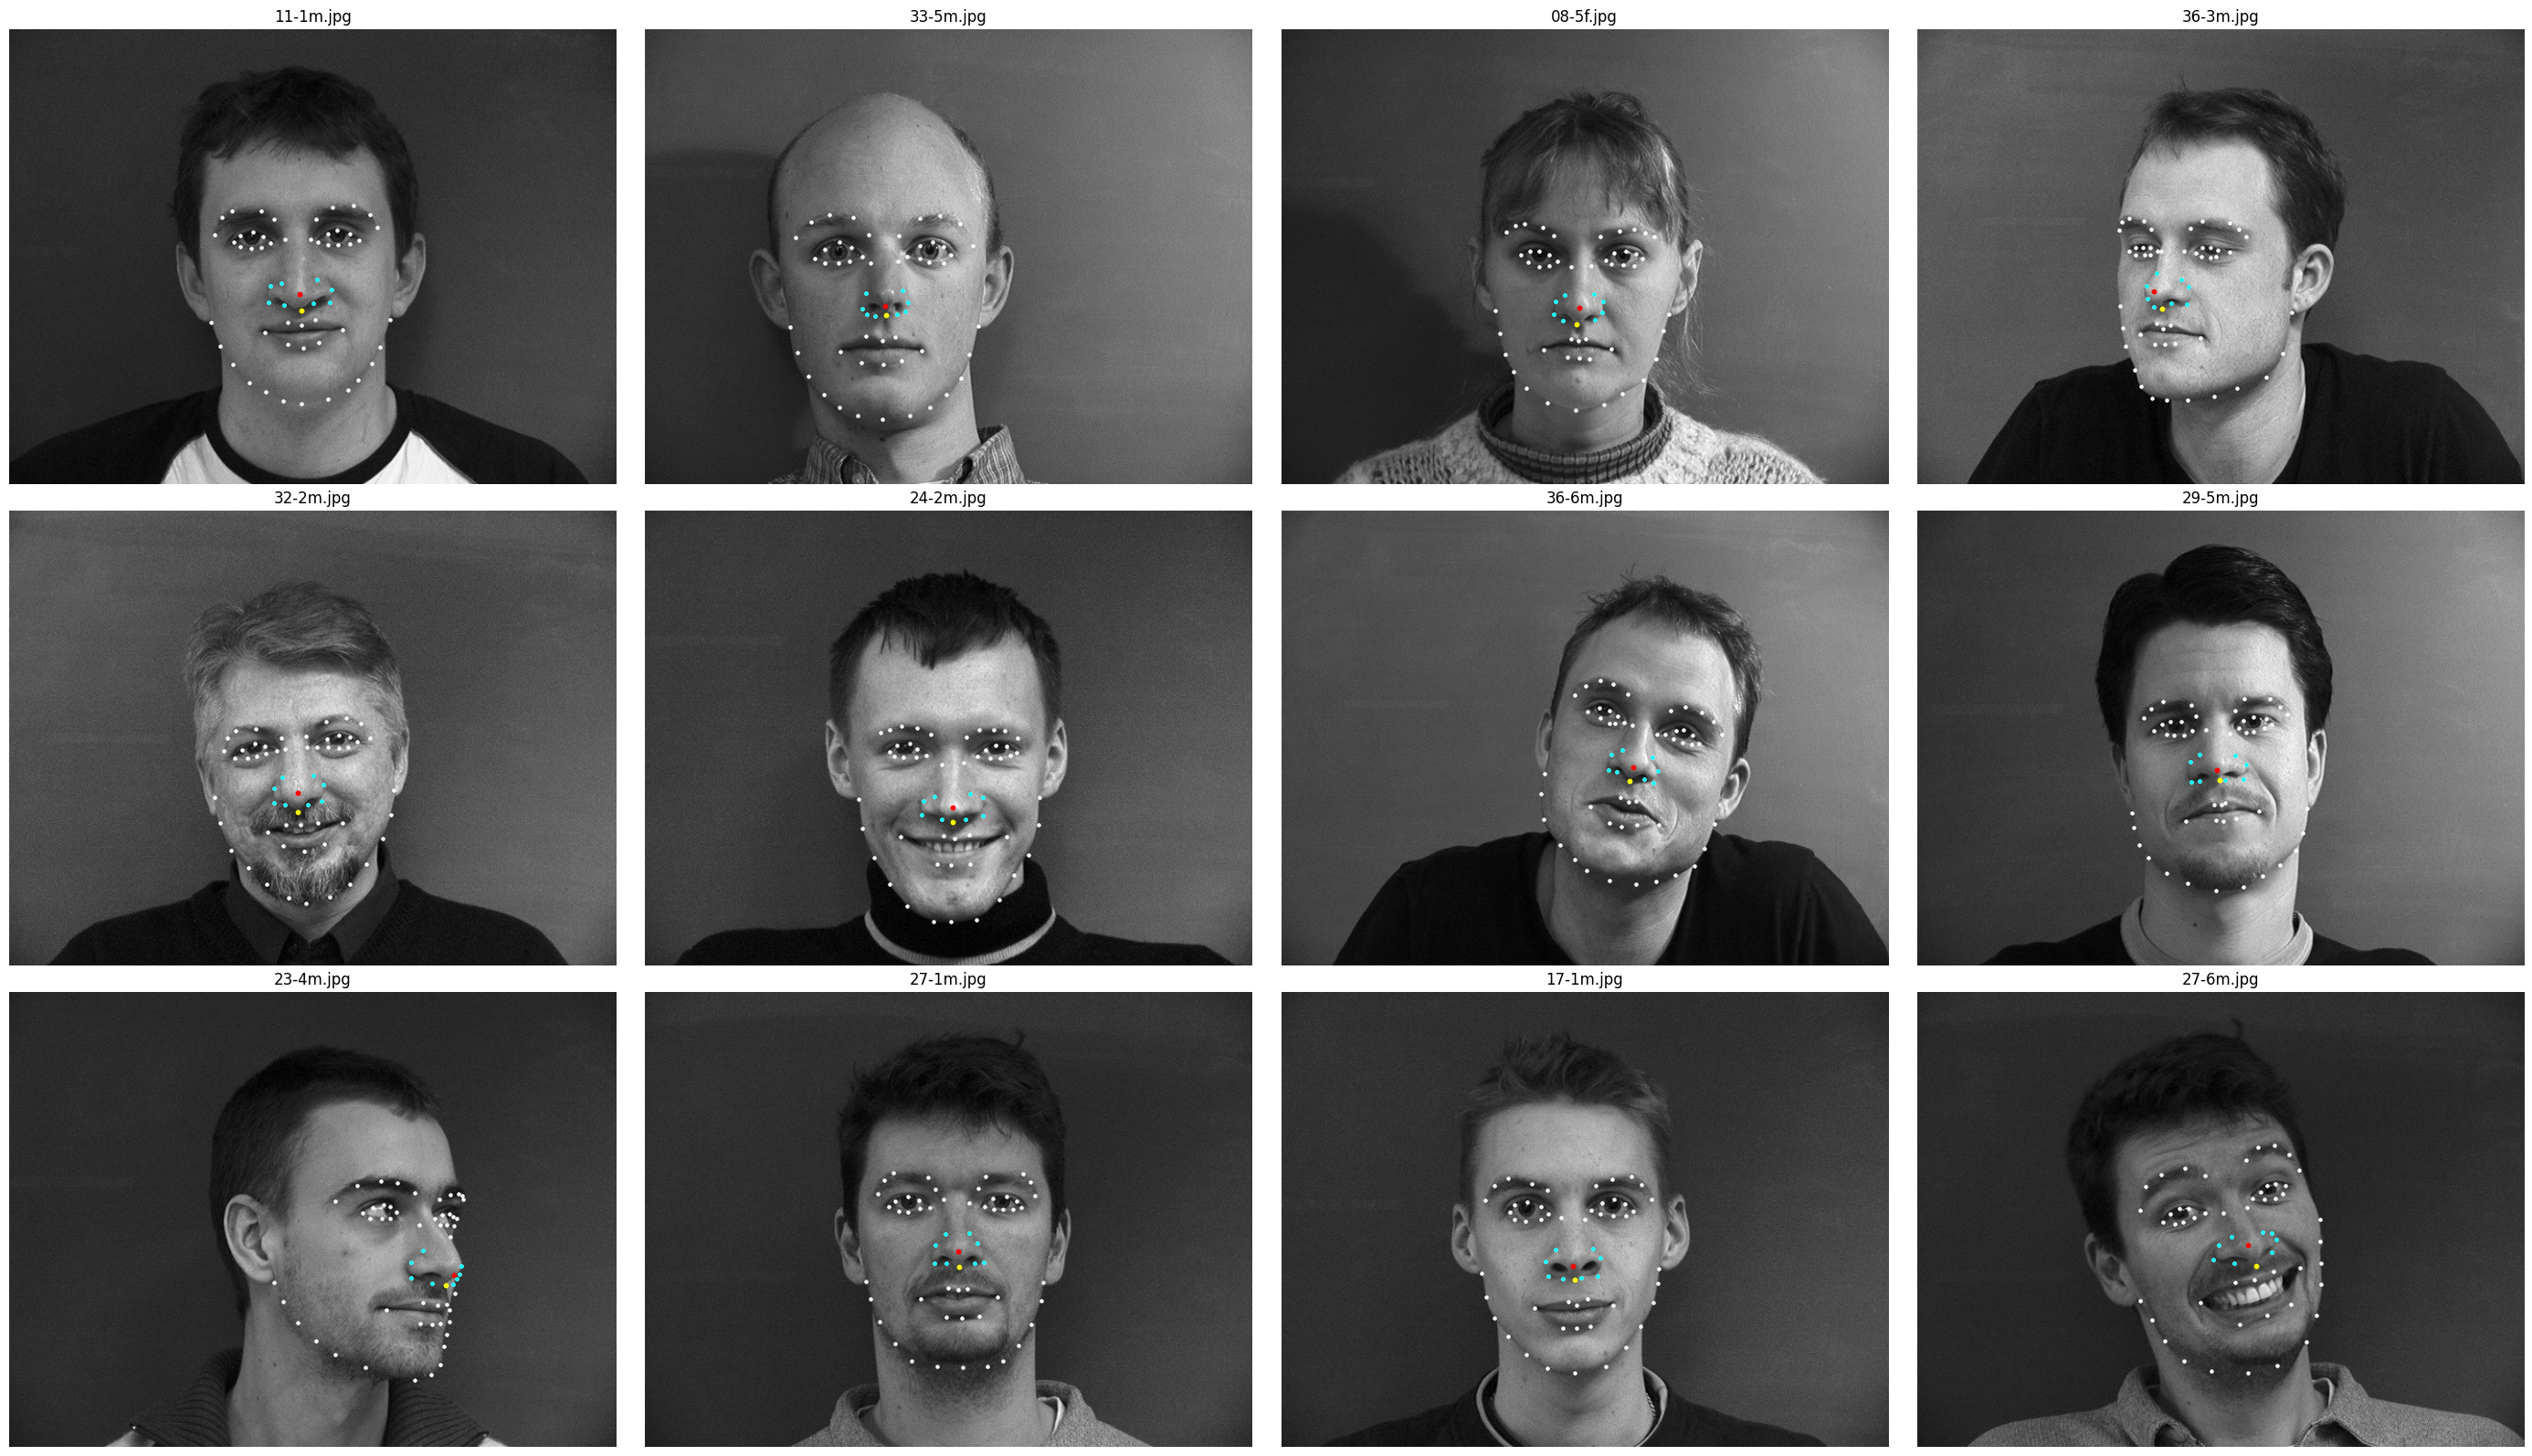

In [31]:
nasal_points_indices = range(48, 57)  # 48 49 50 51 |52| 53 54 55 56

# Create 3x4 subplots
fig, axes = plt.subplots(3, 4, figsize=(28, 16))
axes = axes.flatten()  # Flatten for easier indexing

for i in range(12):
    key = list(images_dict.keys())[i]  # Name
    num = int(key.split('-')[0])
    imgtype = int(key.split('-')[1][0])  # 3 for left side, 4 for right side
    image = images_dict[key][0]
    points_with_info = images_dict[key][1]  # List of tuples (point#, x rel., y rel.)
    
    points = np.array([(point[1] * image.shape[1], point[2] * image.shape[0]) for point in points_with_info])  # (N, 2)
    nasal_points = points[list(nasal_points_indices)]

    # Compute average points for left, right, and middle
    left_sides = nasal_points[:4]
    right_sides = nasal_points[5:]
    left_side = np.mean(left_sides, axis=0)
    right_side = np.mean(right_sides, axis=0)
    middle_side = nasal_points[4]
    
    # Compute nose tip approximation
    t = 0.1 if imgtype == 3 else 0.9 if imgtype == 4 else 0.5
    nose_tip_approx = (1 - t) * left_side + t * right_side

    # Plot on the corresponding subplot
    ax = axes[i]
    ax.imshow(image, cmap='gray')
    # Plot points with different colors
    ax.scatter(points[:, 0], points[:, 1], c='white', s=5)  # All points
    ax.scatter(nose_tip_approx[0], nose_tip_approx[1], c='red', s=10)  # Nose tip approximation
    ax.scatter(nasal_points[:, 0], nasal_points[:, 1], c='cyan', s=5)  # Nasal points
    # show the middle side
    ax.scatter(middle_side[0], middle_side[1], c='yellow', s=10)  # Middle side
    ax.set_title(key)
    ax.axis('off')  # Turn off axis for cleaner visualization

plt.tight_layout()
plt.show()

# II. Dataset

(Assume we have known the nose tip feature point.)

Now we build a training dataset and a validation dataset, with the nose tip feature point as the target, and the image as the input.

We use all 6 images of the first 32 persons (index 1-32) as the training set (total 32 x 6 = 192 images) and the images of the remaining 8 persons (index 33-40) (8 * 6 = 48 images) as the validation set.

In [32]:
# use all 6 images of the first 32 persons (index 1-32) as the training set (total 32 x 6 = 192 images) and the images of the remaining 8 persons (index 33-40) (8 * 6 = 48 images) as the validation set.

# just divide the image_dict into 2 parts
# find the name of file that is like xx-ym or xx-yf, and xx should be in the range of 1-32 for training set, 33-40 for validation set
training_images_dict = {}
validation_images_dict = {}
for key in images_dict.keys():
    num = int(key.split('-')[0])
    if 1 <= num <= 32:
        training_images_dict[key] = images_dict[key]
    elif 33 <= num <= 40:
        validation_images_dict[key] = images_dict[key]
    else:
        print('error')
print(len(training_images_dict), len(validation_images_dict))


192 48


We use the averaging to get the nose tip feature point as the target.

In [33]:
# average all points in the nasal_points_indices
def get_nasal_points_and_new_dict(images_dict):
    nasal_points_dict = {} 
    for key in images_dict.keys():
        image = images_dict[key][0]
        imgtype = int(key.split('-')[1][0]) # 3 then the person is seeing the left side, 4 for the right side
        points_with_info = images_dict[key][1]  # list of tuples (point#, x rel., y rel.)
        h, w = image.shape
        points = np.array([(point[1] * w, point[2] * h) for point in points_with_info]) # (N, 2)
        nasal_points = points[nasal_points_indices]
        left_sides = nasal_points[:4]
        right_sides = nasal_points[5:]
        left_side = np.mean(left_sides, axis=0)
        right_side = np.mean(right_sides, axis=0)
        middle_side = nasal_points[4]
        t = 0.1 if imgtype == 3 else 0.9 if imgtype == 4 else 0.5
        nose_tip_approx = (1 - t) * left_side + t * right_side
        
        if t == 0.5:
            # assert this is equal to np.mean(nasal_points, axis=0)
            nose_tip_approx_2 = nose_tip_approx * 8 / 9 + middle_side / 9
            assert np.allclose(nose_tip_approx_2, np.mean(nasal_points, axis=0))
            
        # relative to the image size
        # back to the format of the asf file
        
        nose_tip_approx_rel = (nose_tip_approx[0] / w, nose_tip_approx[1] / h)
        nasal_points_dict[key] = (image, nose_tip_approx_rel)
    return nasal_points_dict

training_nasal_points_dict = get_nasal_points_and_new_dict(training_images_dict)
validation_nasal_points_dict = get_nasal_points_and_new_dict(validation_images_dict)
print(len(training_nasal_points_dict), len(validation_nasal_points_dict))

192 48


We visualize some of the training images and the corresponding nose tip feature points in the following code:

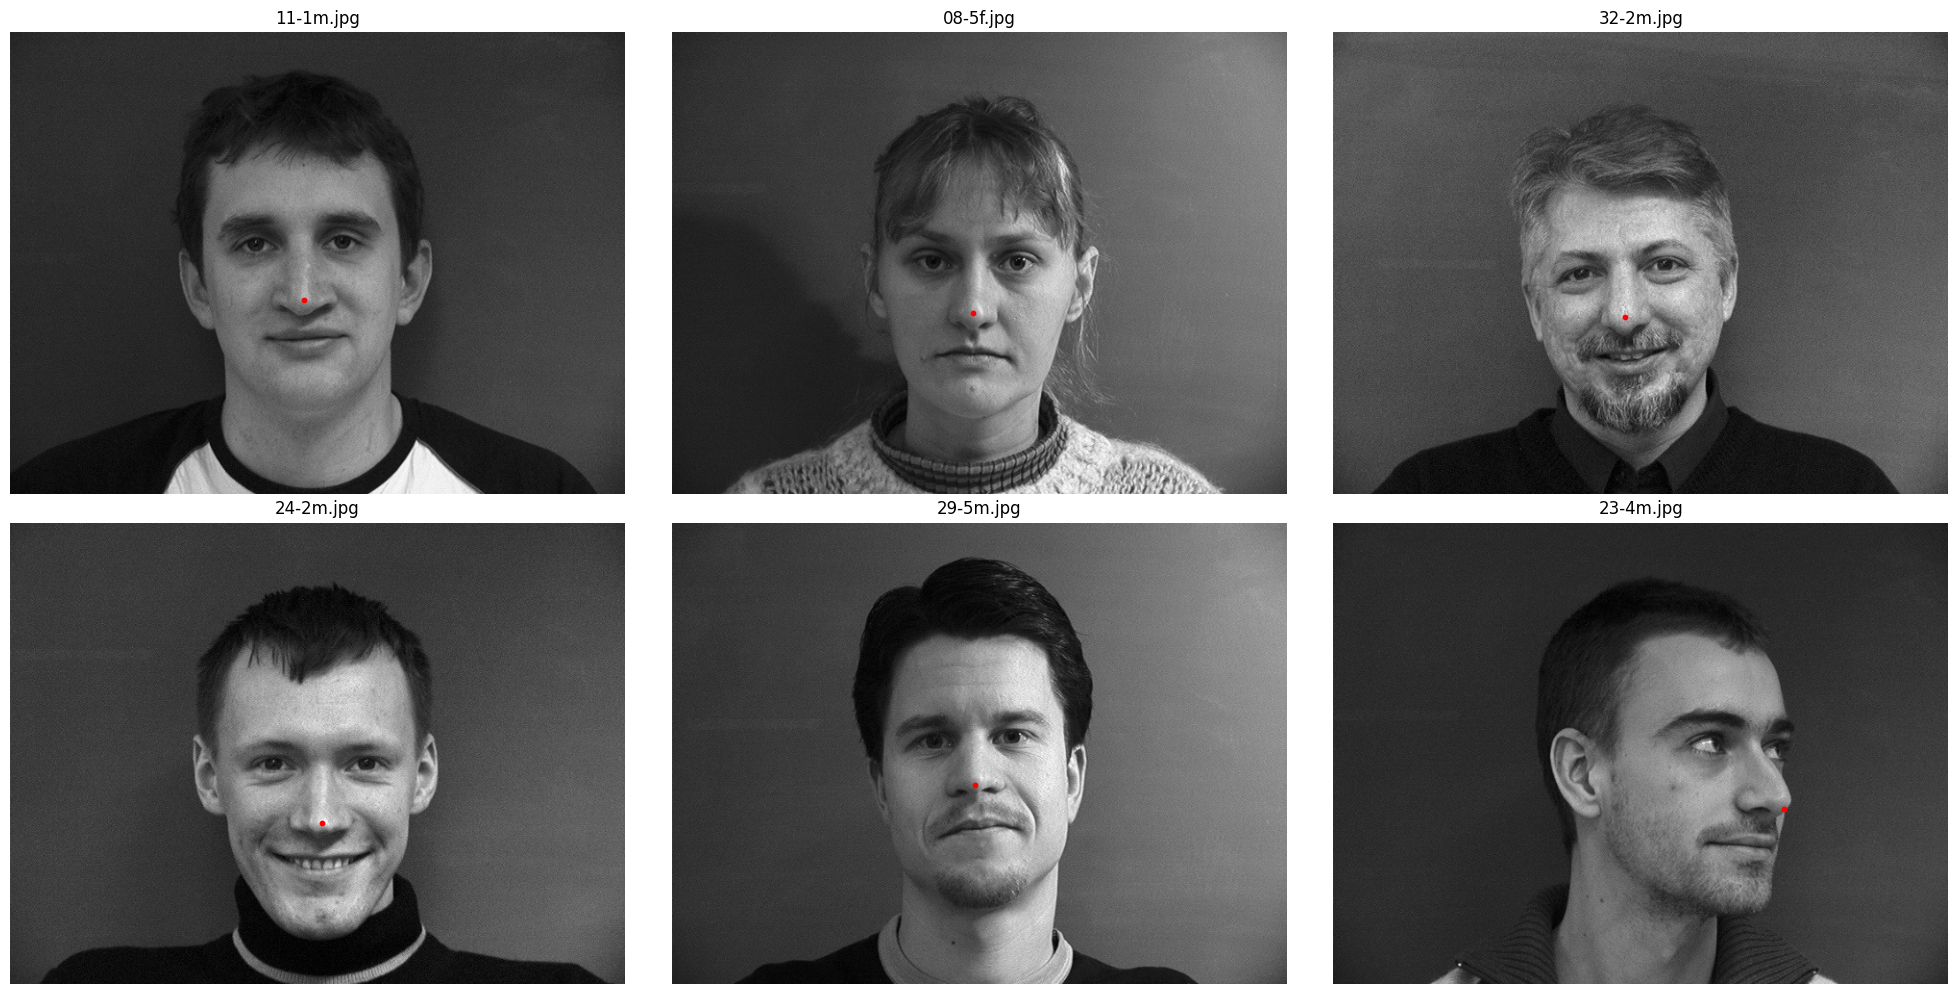

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, key in enumerate(list(training_nasal_points_dict.keys())[:6]):
    image, nasal_point = training_nasal_points_dict[key]
    # NOTE: The nasal point is in relative coordinates, so we need to convert it to absolute coordinates
    # NOTE: SHAPE[1] is width, SHAPE[0] is height, which is the opposite of the usual convention
    nasal_point = (int(nasal_point[0] * image.shape[1]), int(nasal_point[1] * image.shape[0]))
    ax = axes[i]
    ax.imshow(image, cmap='gray')
    ax.scatter(nasal_point[0], nasal_point[1], c='red', s=10)
    ax.set_title(key)
    ax.axis('off')
plt.tight_layout()
plt.show()

Now, we build a dataset class for the training and validation datasets.

In [35]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

In [36]:
class NoseTipDataset(Dataset):
    def __init__(self, nasal_points_dict, transform = None, normalize = True, resize = (80, 60)):
        data = list(nasal_points_dict.values()) # List of (image, nasal_point) tuples
        self.keys = list(nasal_points_dict.keys()) # keys are the names of the images
        self.transform = transform
        assert len(data) == len(self.keys)
        # self.images is a tensor of shape (N, C=1, H, W)
        if resize: # 
            self.images = torch.stack([torch.tensor(cv2.resize(image, resize)).float().unsqueeze(0) for image, _ in data]) # (N, 1, H, W)
        else:
            print('INFO: Not resizing the images')
            self.images = torch.stack([torch.tensor(image).float().unsqueeze(0) for image, _ in data]) # (N, 1, H, W)
        if normalize:
            self.images /= 255.0 # range [0, 1]
            self.images -= 0.5
        else:
            print('INFO: Not normalizing the images')
        # self.nasal_points is a tensor of shape (N, 2)
        self.nasal_points = torch.tensor([point for _, point in data])
        # clamp nasal points to [0, 1]
        self.nasal_points = torch.clamp(self.nasal_points, 0, 1)
        assert self.images.shape[0] == self.nasal_points.shape[0] == len(self.images) == len(self.nasal_points) == len(self.keys)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # self.images is a tensor of shape (N, C=1, H, W)
        # self.nasal_points is a tensor of shape (N, 2)
        image = self.images[idx]
        nasal_point = self.nasal_points[idx]
        if self.transform:
            image = self.transform(image)
        return image, nasal_point


We are also adding transformations to the dataset class to augment the dataset.

In [37]:
train_dataset = NoseTipDataset(training_nasal_points_dict, resize=(80, 60))
val_dataset = NoseTipDataset(validation_nasal_points_dict, resize=(80, 60))
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# III. Model and Training

We use a simple CNN model to predict the nose tip feature point. Our CNNs will use a convolutional layer (`torch.nn.Conv2d`), max pooling layer (`torch.nn.MaxPool2d`) and Rectilinear Unit as non-linearity (`torch.nn.ReLU`). 

The architecture of the neural network should be 3-4 convolutional layers, 12-32 channels each. 

The kernel/filter size for each convolutional layer should be 7x7, 5x5 or 3x3. 

Each convolutional layer will be followed by a ReLU followed by a maxpool. 

Finally, this should be followed by 2 fully connected layers. 

Apply ReLU after the first fully connected layer (but not after the last fully connected layer). You should play around with different design choices to improve your result.

In [38]:
from torch import nn 

In [41]:
# model of 3-4 conv layers, 12-32 channels each, kernel size 7/5/3, 
# each conv layer followed by ReLU and max pooling
class ConvNet(nn.Module): # (N, 1, 80, 60) -> (N, 2)
    def __init__(self, fc_hidden=128):
        super(ConvNet, self).__init__()
        self.fc_hidden = fc_hidden
        self.layers = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=7), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(12, 24, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # fc
            nn.Flatten(),
            nn.Linear(32 * 7 * 4, self.fc_hidden),
            nn.ReLU(),
            nn.Linear(self.fc_hidden, 2)
        )
        
    def forward(self, x):
        return self.layers(x)

Now we have defined the model. We will train the model using the training dataset and validate it using the validation dataset.

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 25
criterion = nn.MSELoss()

def train(model, train_loader, val_loader, optimizer, criterion, epochs=25):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, nasal_points in train_loader:
            optimizer.zero_grad()
            outputs = model(images.to(device).float())
            loss = criterion(outputs, nasal_points.to(device).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, nasal_points in val_loader:
                outputs = model(images.to(device).float())
                loss = criterion(outputs, nasal_points.to(device).float())
                val_loss += loss.item()
            val_loss /= len(val_loader)
        
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
train(model, train_loader, val_loader, optimizer, criterion, epochs=25)




Epoch 1/25: Train Loss: 0.1386, Val Loss: 0.0350
Epoch 2/25: Train Loss: 0.0288, Val Loss: 0.0389
Epoch 3/25: Train Loss: 0.0141, Val Loss: 0.0064
Epoch 4/25: Train Loss: 0.0092, Val Loss: 0.0112
Epoch 5/25: Train Loss: 0.0069, Val Loss: 0.0067
Epoch 6/25: Train Loss: 0.0051, Val Loss: 0.0060
Epoch 7/25: Train Loss: 0.0049, Val Loss: 0.0077
Epoch 8/25: Train Loss: 0.0045, Val Loss: 0.0055
Epoch 9/25: Train Loss: 0.0044, Val Loss: 0.0073
Epoch 10/25: Train Loss: 0.0041, Val Loss: 0.0052
Epoch 11/25: Train Loss: 0.0041, Val Loss: 0.0068
Epoch 12/25: Train Loss: 0.0040, Val Loss: 0.0055
Epoch 13/25: Train Loss: 0.0040, Val Loss: 0.0057
Epoch 14/25: Train Loss: 0.0038, Val Loss: 0.0059
Epoch 15/25: Train Loss: 0.0039, Val Loss: 0.0051
Epoch 16/25: Train Loss: 0.0038, Val Loss: 0.0063
Epoch 17/25: Train Loss: 0.0037, Val Loss: 0.0058
Epoch 18/25: Train Loss: 0.0034, Val Loss: 0.0043
Epoch 19/25: Train Loss: 0.0031, Val Loss: 0.0037
Epoch 20/25: Train Loss: 0.0035, Val Loss: 0.0077
Epoch 21/

# IV. Evaluation

# V. Some stuff

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(15, translate=(0.1, 0.1)), # rotate -15 to 15 degrees, translate 10% of the image size
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])